In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
import seaborn as sns

SBA = pd.read_csv(r"C:\Users\ADMIN\Downloads\SBA_cleaned.csv")

SBA = SBA.drop(columns=['City'])


In [342]:
SBA

,State,NAICS,Term,NoEmp,NewExist,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,IN,45.0,84,4,2.0,1,0,60000.0,48000.0
1,IN,62.0,180,7,1.0,0,0,287000.0,215250.0
2,CT,33.0,120,19,1.0,0,0,517000.0,387750.0
3,FL,81.0,84,1,2.0,1,0,45000.0,36000.0
4,NC,81.0,84,1,2.0,1,0,70000.0,56000.0
...,...,...,...,...,...,...,...,...,...
486639,CA,32.0,240,8,1.0,0,0,189000.0,189000.0
486640,MN,62.0,108,1,1.0,0,0,169000.0,126750.0
486641,SC,11.0,120,2,1.0,0,0,45000.0,22500.0
486642,MD,33.0,60,20,1.0,0,0,50000.0,25000.0


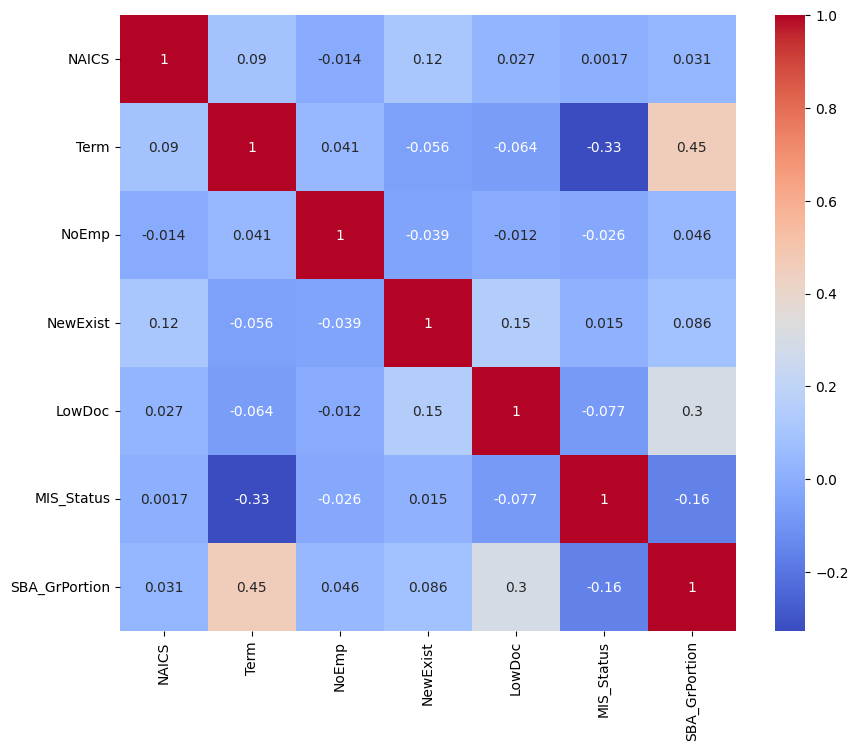

In [343]:
SBA['SBA_GrPortion']=SBA['SBA_Appv'] / SBA['GrAppv']
SBA=SBA.drop(['GrAppv','SBA_Appv'],axis=1)

numeric_columns = SBA.select_dtypes(include='number')
corr_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

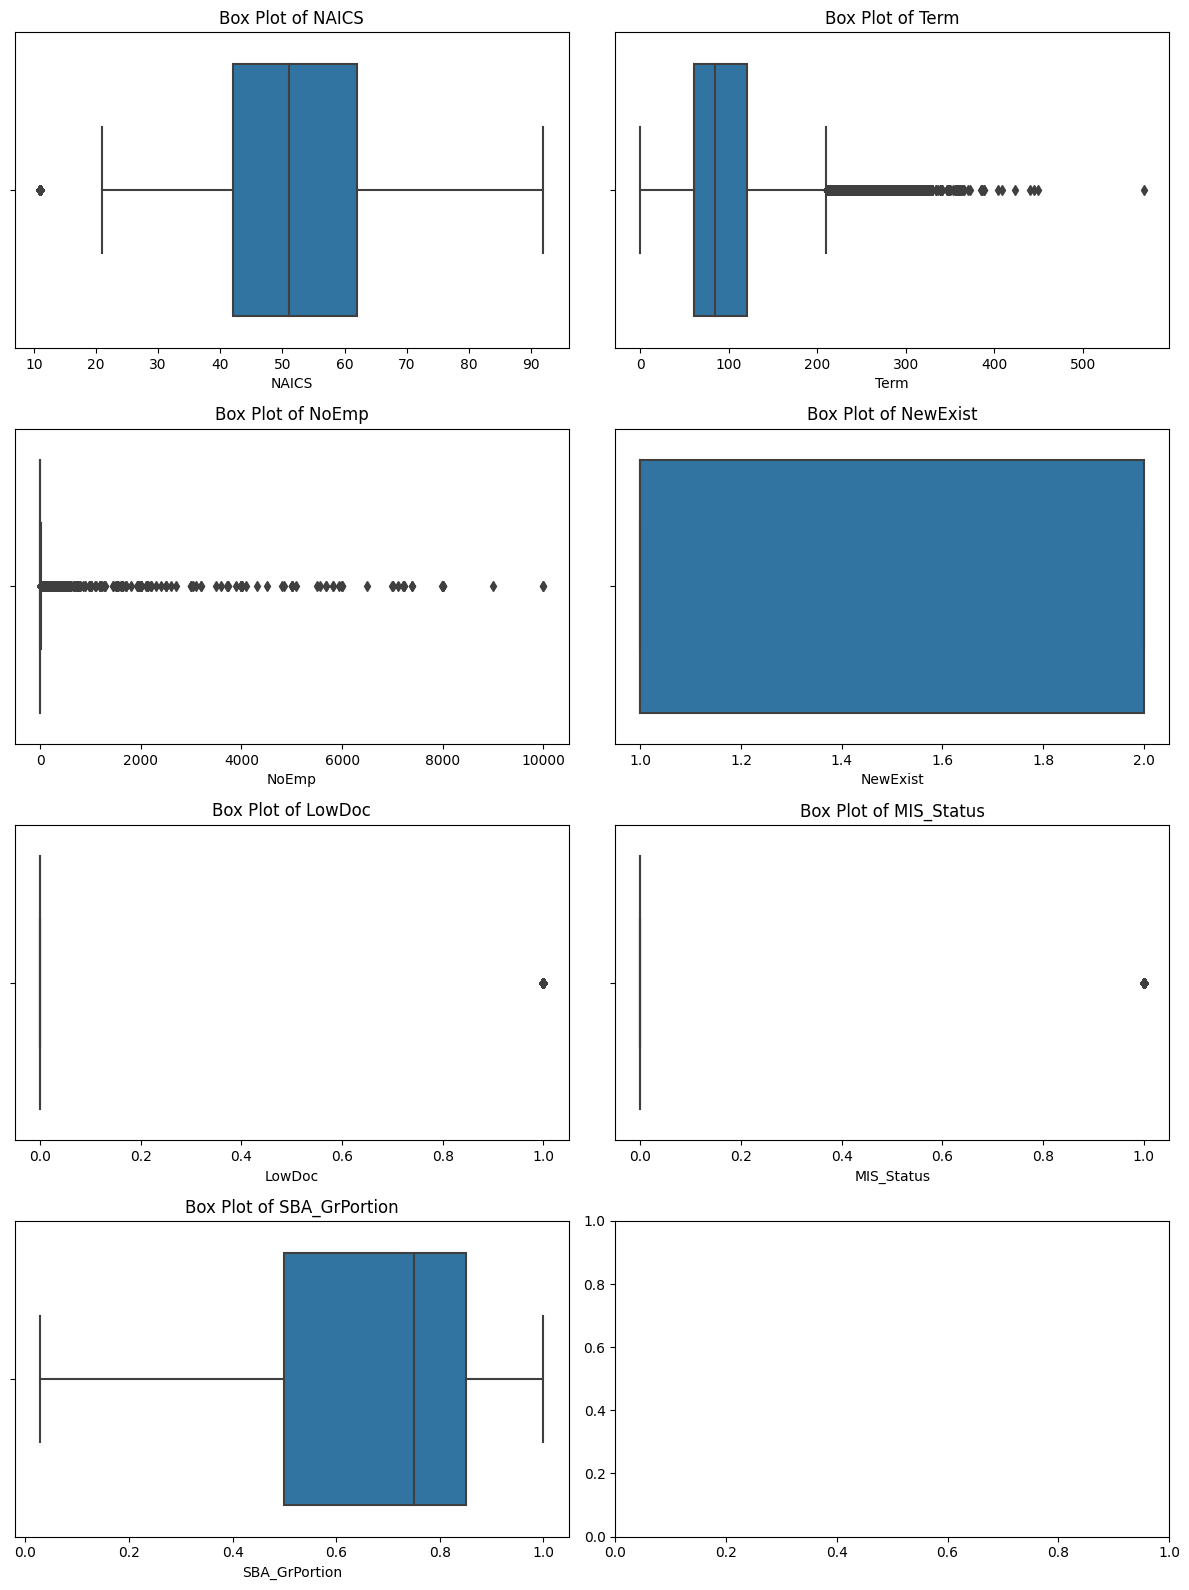

In [344]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

for i, column in enumerate(numeric_columns):
    row = i // 2
    col = i % 2
    sns.boxplot(x=numeric_columns[column], ax=axs[row, col])
    axs[row, col].set_xlabel(column)
    axs[row, col].set_title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()


<sub> Since the accuracy before and after removing outliers for each feature was not significant, we decided not to remove them, except for the 'NoEmp' feature, where we observed a slight improvement after removing outliers
</sub>

In [345]:
columns = ['NoEmp']

for column in columns:

    # Calculate the IQR for column
    Q1 = SBA[column].quantile(0.25)
    Q3 = SBA[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    # Remove outliers in the column
    outliers_term = SBA[(SBA[column] < lower) | (SBA[column] > upper)]
    SBA = SBA.drop(outliers_term.index)

In [346]:
# one_hot_encoded = pd.get_dummies(SBA['State'])

# box = [
# 'NoEmp',
# 'NewExist',
# 'Term',
# 'LowDoc',
# 'SBA_GrPortion',
# 'MIS_Status'
# ]
# # Concatenate the original DataFrame with the one-hot encoded columns
# SBA = pd.concat([SBA[box], one_hot_encoded], axis=1)
# # df_encoded = pd.concat([df_encoded, df[box]], axis=1)
# # Print the encoded DataFrame
# SBA

In [347]:
# nan_count = SBA.isnull().sum()

# print(f"Nan: {nan_count}")


In [348]:
X = SBA.drop(['MIS_Status','State'], axis=1)
y = SBA['MIS_Status']

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state=12,
                                                    stratify=y)



In [350]:
knn = KNeighborsClassifier(n_neighbors=5)
cross_val_score(knn, X, y, cv=10, scoring='accuracy', n_jobs=-1).mean()

0.9095802250578453

In [351]:
cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy', n_jobs=5).mean()

0.9141143886711136

In [352]:
cross_val_score(knn, X_test, y_test, cv=10, scoring='accuracy', n_jobs=5).mean()

0.9069786839666358

In [353]:
k_range = range(1,14 )
acc_scores = []

for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=10, scoring='accuracy', n_jobs=5).mean()
    acc_scores.append(score)



100%|██████████| 13/13 [02:04<00:00,  9.56s/it]


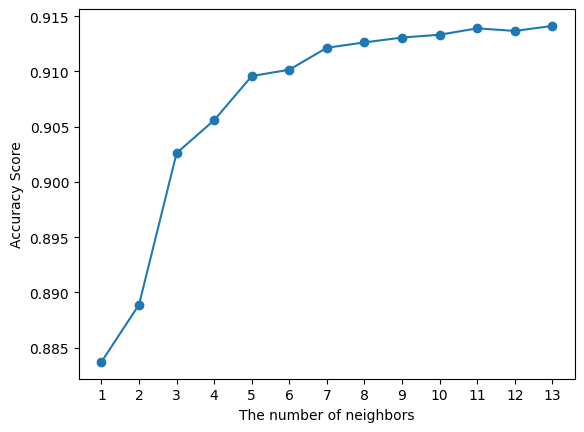

In [354]:
plt.plot(k_range, acc_scores, marker='o')
plt.xlabel('The number of neighbors')
plt.ylabel('Accuracy Score')
plt.xticks(range(1, 14))
plt.show()

# KNN with All features

In [355]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [356]:
features = ['State','NAICS', 'Term', 'NoEmp', 'NewExist','LowDoc','SBA_GrPortion']
# Prepare inputs 
X = SBA[features]
y = SBA['MIS_Status']

In [357]:

ohe = OneHotEncoder()
ct = make_column_transformer((ohe, ['State']),
                             remainder='passthrough')



In [358]:
pipe = make_pipeline(ct, knn)

In [359]:
pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['State'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=13))])

In [360]:
%%time
cross_val_score(pipe, X, y, cv=10, scoring='accuracy', n_jobs=-1).mean()

CPU times: total: 297 ms
Wall time: 15min 47s


0.9127382449073315